In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
import mlp_mixer_pytorch
import mlp_shaker_flat

In [24]:
torch.manual_seed(0)
np.random.seed(0)

def create_linear_dataset(N, M, n_samp_train, n_samp_test):
    M = torch.randn(M, N)
    X = torch.randn(n_samp_train+n_samp_test, N)
    Y = X@M.T
    X_train, X_test = X.split([n_samp_train, n_samp_test])
    Y_train, Y_test = Y.split([n_samp_train, n_samp_test])
    return X_train, Y_train, X_test, Y_test

def create_linearbot_dataset(N, M, bottleneck, n_samp_train, n_samp_test):
    M1 = torch.randn(bottleneck, N)
    M2 = torch.randn(M, bottleneck)
    X = torch.randn(n_samp_train+n_samp_test, N)
    Y = (X@M1.T)@M2.T
    X_train, X_test = X.split([n_samp_train, n_samp_test])
    Y_train, Y_test = Y.split([n_samp_train, n_samp_test])
    return X_train, Y_train, X_test, Y_test

def create_nonlinear_dataset(N, M, n_samp_train, n_samp_test):
    M = torch.randn(M, N)
    X = torch.randn(n_samp_train+n_samp_test, N)
    Y = (X.sin()@M.T).tanh()
    X_train, X_test = X.split([n_samp_train, n_samp_test])
    Y_train, Y_test = Y.split([n_samp_train, n_samp_test])
    return X_train, Y_train, X_test, Y_test
    

# X_train, Y_train, X_test, Y_test = create_linear_dataset(16, 16, 9999, 999)
X_train, Y_train, X_test, Y_test = create_linearbot_dataset(16, 16, 4, 9999, 999)
# X_train, Y_train, X_test, Y_test = create_nonlinear_dataset(100, 100, 9999, 999)

In [25]:
def evaluate(net, train='False', device=None, bs=300, verbose=False):
    net = net.to(device)
    losses = []
    if train:
        X, Y = X_train, Y_train
    else:
        X, Y = X_test, Y_test
#     for X_batch, Y_batch in tqdm(zip(X.split(bs), Y.split(bs)), leave=False, total=math.ceil(len(X)/bs)):
    for X_batch, Y_batch in zip(X.split(bs), Y.split(bs)):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_batch_pred = net(X_batch)
        loss = (Y_batch_pred-Y_batch).pow(2.).mean().item()
        losses.append(loss)
    losses = np.mean(losses)
    if verbose:
        print(f'Average Loss: {losses}')
    return {'loss': losses}
    
def train(net, lr=1e-2, device=None, n_epochs=10, bs=300):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    losses_train, losses_test = [], []
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
#         for X_batch, Y_batch in tqdm(zip(X_train.split(bs), Y_train.split(bs)), leave=False, total=math.ceil(len(X_train)/bs)):
        for X_batch, Y_batch in zip(X_train.split(bs), Y_train.split(bs)):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)
            loss = (Y_batch_pred-Y_batch).pow(2.).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
        losses_train.append(evaluate(net, train=True, bs=bs, device=device)['loss'])
        losses_test.append(evaluate(net, train=False, bs=bs, device=device)['loss'])
        loop.set_postfix({'train loss': losses_train[-1], 'test loss': losses_train[-1]})
    plt.plot(losses_train, label='training loss')
    plt.plot(losses_test, label='testing loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()

In [26]:
from mlp_mixer_pytorch import HeadlessMLPMixer

# params:  272


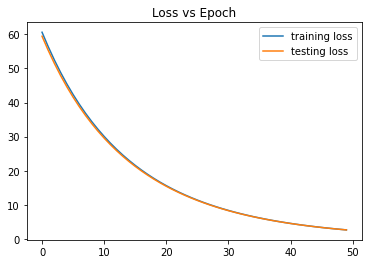

In [27]:
net = nn.Linear(16, 16)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=50)

# params:  5760


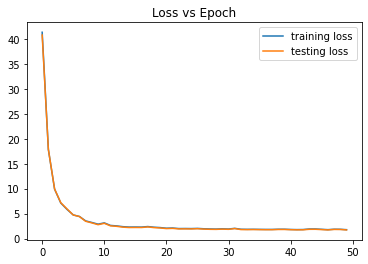

In [28]:
net = mlp_shaker_flat.MLPFlatShaker([16], [0]*10, )
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=50)

# params:  480


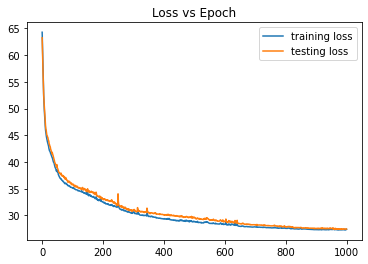

In [29]:
net = mlp_shaker_flat.MLPFlatShaker([4, 4], [0, 1]*5, ).to(device)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=1000)

In [23]:
net = HeadlessMLPMixer(4, 4, depth=10)
print('# params: ', util.count_params(net))
train(net, device=device, lr=1e-2, bs=1000, n_epochs=1000)

# params:  3120


KeyboardInterrupt: 

In [4]:
import dim_models

In [5]:
net = nn.Linear(100, 100).to(device)

In [12]:
%%timeit
net(torch.randn(500, 200, 100).to(device))

79.4 ms ± 576 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
net = dim_models.DimLinear(100, 100, shape=[200, 100], dim_to_mix=1).to(device)

In [14]:
%%timeit
net(torch.randn(500, 200, 100).to(device))

79.2 ms ± 766 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
net = dim_models.DimLinear(100, 100, shape=[100, 200], dim_to_mix=0).to(device)

In [16]:
%%timeit
net(torch.randn(500, 100, 200).to(device))

78.8 ms ± 803 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
a = torch.randn(7777, 100).to(device)
b = torch.randn(100, 90).to(device)

In [48]:
%%timeit
c = a@b

45.8 µs ± 299 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
%%timeit
c = (a[..., None]*b).sum(dim=-2)

2.34 ms ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
a = torch.randn(7777, 100, 1).to(device)
b = torch.randn(7777, 100, 90).to(device)

In [51]:
%%timeit
c = (a*b).sum(dim=-2)

2.3 ms ± 206 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
